# Convolutional neural network for classifying Root data fits.


Here, we define, train, and save new convolutional models as well as some 
simple model evaluation. We define hyper-parameters, number of layers, and 
training and testing datasets. 

Here, at the final layer, the network takes into account chi squared per degree of freedom.

#### Load necessary packages

In [1]:
# Load some packages

# Keras packages for network
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, Conv2D, Flatten
from keras.models import Model
from keras.optimizers import Adam, SGD
# For saving model
from keras.models import model_from_json
from keras.layers import concatenate, Lambda

# Some items for plotting and drawing
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from PIL import Image
from scipy import misc
import matplotlib.pyplot as plt

# Need numpy
import numpy as np
import nn_utils as utils

%matplotlib inline

Using TensorFlow backend.


#### Load root fit data from file

In [2]:
# Define image file path
im_path="/media/brady/4be7777f-c84c-40ca-af3a-b8c6e4f2f90d/brady/Projects/fit_pmt/images/png_fit_nn/"

# Load dataset
x, y, params = utils.load_dataset_all(im_dir="train", log=False, im_path=im_path)
x_dev, y_dev, params_dev = utils.load_dataset_all(im_dir="dev", log=False, im_path=im_path)

# Grab dimensions of picture
(m, h, w, c) = x.shape
m_dev = x_dev.shape[0]
input_shape = h, w, c
num_params = params.shape[1]

# Print dimensions
print("(m, height, width, channels): (" + str(m) + ", " + str(h) + ", " + str(w) + ", " + str(c) + ")")
print("m_dev: " + str(m_dev))
print("y: " + str(y.shape))
print("params: " + str(params.shape))


(m, height, width, channels): (1396, 236, 348, 3)
m_dev: 129
y: (1396, 1)
params: (1396, 54)


label: good
label: [1]
params: [ 0.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  2.000000e+01
  5.000000e-02  6.144692e+02  2.252700e+00  1.000000e-02  2.560000e+00
  4.000000e+00  2.252700e+00  5.000000e-01  5.000000e-01  1.000000e-03
 -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00
 -1.000000e+00  0.000000e+00  0.000000e+00  5.000000e-01 -1.000000e+00
 -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00
  1.000000e+00  1.000000e+00  6.400000e-03  6.130692e+02  1.706800e+00
  5.000000e-02  5.411800e+00  1.132900e+00  1.556800e+00  1.765000e-01
  8.235000e-01  2.000000e-04  1.620000e-02  1.270000e-02  1.000000e-03
  8.910000e-02  1.870000e-02  1.070000e-02  2.800000e-03  3.000000e-03
  6.254000e+00  1.768000e-01  7.300000e-03  4.130900e+00]


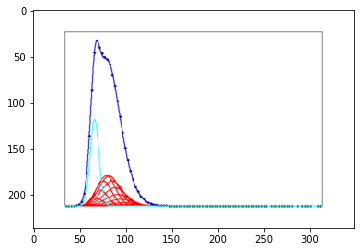

In [3]:
# Print an image
index = 420
this_image = x[index]
if y[index] == 1:
    print("label: good")
else:
    print("label: bad")
print("label: " + str(y[index]))
print("params: " + str(params[index]))
plt.imshow(np.uint8(utils.get_printable_image(this_image)))

## Define and Train multi-layer ConvNet with 2 fully connected layers plus output layer

For the convolutional layer, we will scan over our images with a certain stride and a certain kernal size. 
Each individual scan represents a single neuron in the next layer. Since each scan connects to kernal size squared
neurons below it, convolutions reduce the number of degrees of freedom. Hopefully, through learning the right filters,
we can preserve the important information as we reduce it in size.

Once the image has gone through the convolutional layers (and therefore has been reduced to its features vector), we
can send the resulting vector into some old-fashioned fully-connected layers, and finally into a logistic regression unit.

##### Define hyperparameters

In [4]:
# Initialize
filters = []
kernels = []
strides = []
pools = []
dropouts = []

# Conv1
filters.append(32)
kernels.append(5)
strides.append(2)
pools.append(2)
dropouts.append(0.4)

# Conv2
filters.append(128)
kernels.append(5)
strides.append(2)
pools.append(2)
dropouts.append(0.3)

# Conv3
filters.append(256)
kernels.append(4)
strides.append(2)
pools.append(2)
dropouts.append(0.2)

# Define dense (fully-connected) layer sizes
fc1 = 40
fc2 = 20
fc3 = 20

##### Define keras layers (model)

In [5]:
def concat_params(input):
    a = input[0]
    b = input[1]
    return concatenate([a,b], axis=1)

In [6]:
# Define input layer (RGB image matrix)
X = Input(shape=input_shape, name='Input')

# Define additional input info
Params = Input(shape=(num_params,), name='Params')

# Initialize activation as input
a = X
# Loop through all convolutional layers
for i in range(len(filters)):
    # Perform convolution
    a = Conv2D(filters=filters[i], kernel_size=(kernels[i], kernels[i]), strides=(strides[i], strides[i]), name=('conv' + str(i)))(a)
    # Normalize
    a = BatchNormalization(axis=3, name=('bn' + str(i)))(a)
    # Activate
    a = Activation('relu', name=('a' + str(i)))(a)
    # Max-pool
    a = MaxPooling2D((pools[i], pools[i]), name=('max_pool' + str(i)))(a)
    # Dropout
    a = Dropout(rate=dropouts[i])(a)

# Flatten output of convNet
a = Flatten()(a)
# Define first fully connected layer
a = Dense(units=fc1, activation='relu', name='fc0')(a)
# Use some dropout here for regularization
a = Dropout(rate=0.3)(a)

# Activate parameters
a_params = Activation('tanh', name='param_act')(Params)

# Concatenate parameters to activations
a = Lambda(concat_params, name='concat_params')([a, a_params])

# Define second fully connected layer
a = Dense(units=fc2, activation='relu', name='fc1')(a)
# Use some dropout here for regularization
a = Dropout(rate=0.3)(a)
# Define second fully connected layer
a = Dense(units=fc3, activation='relu', name='fc2')(a)

# Define output layer 
a = Dense(units=1, activation='sigmoid', name='sigmoid')(a)

# Make the model
model = Model(inputs=[X, Params], outputs=a)

##### Define optimizer, loss, and metrics. Compile model.

In [7]:
# Define optimizer
#opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.001)
opt = SGD(lr=1.0, decay=1e-6, momentum=0.9, nesterov=True)
# Define loss
loss = 'mean_squared_error'
# Define metrics to use
metrics=['acc']
# Compile model
model.compile(loss=loss, optimizer='sgd', metrics=metrics)
# Print summary
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 236, 348, 3)  0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 116, 172, 32) 2432        Input[0][0]                      
__________________________________________________________________________________________________
bn0 (BatchNormalization)        (None, 116, 172, 32) 128         conv0[0][0]                      
__________________________________________________________________________________________________
a0 (Activation)                 (None, 116, 172, 32) 0           bn0[0][0]                        
__________________________________________________________________________________________________
max_pool0 

##### Fit the model to the data (train)

Train on 1396 samples, validate on 129 samples
Epoch 1/1000
1396/1396 [==============================] - 6s 4ms/step - loss: 0.3012 - acc: 0.4721 - val_loss: 0.2666 - val_acc: 0.4031
Epoch 2/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.2739 - acc: 0.5244 - val_loss: 0.2598 - val_acc: 0.4496
Epoch 3/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.2679 - acc: 0.5086 - val_loss: 0.2535 - val_acc: 0.4961
Epoch 4/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.2600 - acc: 0.5337 - val_loss: 0.2515 - val_acc: 0.5116
Epoch 5/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.2527 - acc: 0.5408 - val_loss: 0.2479 - val_acc: 0.5271
Epoch 6/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.2564 - acc: 0.5201 - val_loss: 0.2450 - val_acc: 0.5039
Epoch 7/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.2500 - acc: 0.5473 - val_loss: 0.2365 - val_acc: 0.6202
E

1396/1396 [==============================] - 4s 3ms/step - loss: 0.1873 - acc: 0.6984 - val_loss: 0.1797 - val_acc: 0.7674
Epoch 61/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1902 - acc: 0.7006 - val_loss: 0.1812 - val_acc: 0.7674
Epoch 62/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1858 - acc: 0.7185 - val_loss: 0.1803 - val_acc: 0.7597
Epoch 63/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1875 - acc: 0.7013 - val_loss: 0.1799 - val_acc: 0.7597
Epoch 64/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1870 - acc: 0.7192 - val_loss: 0.1803 - val_acc: 0.7597
Epoch 65/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1896 - acc: 0.7063 - val_loss: 0.1795 - val_acc: 0.7597
Epoch 66/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1863 - acc: 0.7163 - val_loss: 0.1783 - val_acc: 0.7597
Epoch 67/1000
1396/1396 [==============================

Epoch 120/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1565 - acc: 0.7729 - val_loss: 0.1589 - val_acc: 0.7519
Epoch 121/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1518 - acc: 0.7765 - val_loss: 0.1581 - val_acc: 0.7597
Epoch 122/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1534 - acc: 0.7758 - val_loss: 0.1593 - val_acc: 0.7597
Epoch 123/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1560 - acc: 0.7679 - val_loss: 0.1597 - val_acc: 0.7597
Epoch 124/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1520 - acc: 0.7880 - val_loss: 0.1585 - val_acc: 0.7519
Epoch 125/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1526 - acc: 0.7708 - val_loss: 0.1588 - val_acc: 0.7519
Epoch 126/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1483 - acc: 0.7923 - val_loss: 0.1574 - val_acc: 0.7597
Epoch 127/1000
1396/1396 [========

1396/1396 [==============================] - 4s 3ms/step - loss: 0.1235 - acc: 0.8223 - val_loss: 0.1589 - val_acc: 0.7287
Epoch 180/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1282 - acc: 0.8209 - val_loss: 0.1578 - val_acc: 0.7442
Epoch 181/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1228 - acc: 0.8338 - val_loss: 0.1564 - val_acc: 0.7519
Epoch 182/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1237 - acc: 0.8238 - val_loss: 0.1595 - val_acc: 0.7442
Epoch 183/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1218 - acc: 0.8360 - val_loss: 0.1592 - val_acc: 0.7442
Epoch 184/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1269 - acc: 0.8109 - val_loss: 0.1609 - val_acc: 0.7287
Epoch 185/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1238 - acc: 0.8274 - val_loss: 0.1596 - val_acc: 0.7442
Epoch 186/1000
1396/1396 [=======================

1396/1396 [==============================] - 4s 3ms/step - loss: 0.1003 - acc: 0.8646 - val_loss: 0.1624 - val_acc: 0.7519
Epoch 239/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1064 - acc: 0.8517 - val_loss: 0.1650 - val_acc: 0.7209
Epoch 240/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0946 - acc: 0.8725 - val_loss: 0.1596 - val_acc: 0.7442
Epoch 241/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1018 - acc: 0.8625 - val_loss: 0.1622 - val_acc: 0.7442
Epoch 242/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0964 - acc: 0.8804 - val_loss: 0.1670 - val_acc: 0.7287
Epoch 243/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1049 - acc: 0.8582 - val_loss: 0.1638 - val_acc: 0.7364
Epoch 244/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0977 - acc: 0.8696 - val_loss: 0.1750 - val_acc: 0.7054
Epoch 245/1000
1396/1396 [=======================

1396/1396 [==============================] - 4s 3ms/step - loss: 0.0927 - acc: 0.8761 - val_loss: 0.1641 - val_acc: 0.7209
Epoch 298/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0883 - acc: 0.8818 - val_loss: 0.1775 - val_acc: 0.6977
Epoch 299/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0967 - acc: 0.8653 - val_loss: 0.1776 - val_acc: 0.6899
Epoch 300/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0817 - acc: 0.8883 - val_loss: 0.1789 - val_acc: 0.6977
Epoch 301/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0822 - acc: 0.8961 - val_loss: 0.1735 - val_acc: 0.7054
Epoch 302/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0849 - acc: 0.8926 - val_loss: 0.1702 - val_acc: 0.7132
Epoch 303/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0826 - acc: 0.8940 - val_loss: 0.1734 - val_acc: 0.7209
Epoch 304/1000
1396/1396 [=======================

1396/1396 [==============================] - 4s 3ms/step - loss: 0.0790 - acc: 0.8897 - val_loss: 0.1684 - val_acc: 0.7287
Epoch 357/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0754 - acc: 0.9033 - val_loss: 0.1713 - val_acc: 0.7132
Epoch 358/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0731 - acc: 0.8976 - val_loss: 0.1810 - val_acc: 0.6822
Epoch 359/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0709 - acc: 0.9090 - val_loss: 0.1738 - val_acc: 0.6977
Epoch 360/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0742 - acc: 0.8983 - val_loss: 0.1775 - val_acc: 0.6822
Epoch 361/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0725 - acc: 0.8997 - val_loss: 0.1826 - val_acc: 0.6822
Epoch 362/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0721 - acc: 0.9062 - val_loss: 0.1715 - val_acc: 0.7132
Epoch 363/1000
1396/1396 [=======================

1396/1396 [==============================] - 4s 3ms/step - loss: 0.0704 - acc: 0.9062 - val_loss: 0.1640 - val_acc: 0.7364
Epoch 416/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0716 - acc: 0.9097 - val_loss: 0.1693 - val_acc: 0.7132
Epoch 417/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0653 - acc: 0.9183 - val_loss: 0.1669 - val_acc: 0.7209
Epoch 418/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0631 - acc: 0.9219 - val_loss: 0.1553 - val_acc: 0.7597
Epoch 419/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0609 - acc: 0.9198 - val_loss: 0.1576 - val_acc: 0.7364
Epoch 420/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0633 - acc: 0.9241 - val_loss: 0.1765 - val_acc: 0.6899
Epoch 421/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0628 - acc: 0.9219 - val_loss: 0.1719 - val_acc: 0.7054
Epoch 422/1000
1396/1396 [=======================

1396/1396 [==============================] - 4s 3ms/step - loss: 0.0564 - acc: 0.9284 - val_loss: 0.1499 - val_acc: 0.7752
Epoch 475/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0570 - acc: 0.9291 - val_loss: 0.1695 - val_acc: 0.7287
Epoch 476/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0590 - acc: 0.9191 - val_loss: 0.1545 - val_acc: 0.7752
Epoch 477/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0541 - acc: 0.9305 - val_loss: 0.1709 - val_acc: 0.7209
Epoch 478/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0581 - acc: 0.9226 - val_loss: 0.1605 - val_acc: 0.7364
Epoch 479/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0588 - acc: 0.9219 - val_loss: 0.1521 - val_acc: 0.7674
Epoch 480/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0562 - acc: 0.9312 - val_loss: 0.1505 - val_acc: 0.7674
Epoch 481/1000
1396/1396 [=======================

1396/1396 [==============================] - 4s 3ms/step - loss: 0.0557 - acc: 0.9284 - val_loss: 0.1755 - val_acc: 0.7519
Epoch 534/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0491 - acc: 0.9370 - val_loss: 0.1695 - val_acc: 0.7752
Epoch 535/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0500 - acc: 0.9355 - val_loss: 0.1720 - val_acc: 0.7674
Epoch 536/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0528 - acc: 0.9319 - val_loss: 0.1587 - val_acc: 0.7907
Epoch 537/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0508 - acc: 0.9370 - val_loss: 0.1689 - val_acc: 0.7442
Epoch 538/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0462 - acc: 0.9448 - val_loss: 0.1633 - val_acc: 0.7597
Epoch 539/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0508 - acc: 0.9377 - val_loss: 0.1571 - val_acc: 0.7674
Epoch 540/1000
1396/1396 [=======================

1396/1396 [==============================] - 4s 3ms/step - loss: 0.0470 - acc: 0.9470 - val_loss: 0.1521 - val_acc: 0.8062
Epoch 593/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0439 - acc: 0.9463 - val_loss: 0.1420 - val_acc: 0.8062
Epoch 594/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0457 - acc: 0.9427 - val_loss: 0.1661 - val_acc: 0.7597
Epoch 595/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0395 - acc: 0.9506 - val_loss: 0.1723 - val_acc: 0.7519
Epoch 596/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0436 - acc: 0.9499 - val_loss: 0.1619 - val_acc: 0.7597
Epoch 597/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0464 - acc: 0.9391 - val_loss: 0.1536 - val_acc: 0.7907
Epoch 598/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0446 - acc: 0.9448 - val_loss: 0.1576 - val_acc: 0.7829
Epoch 599/1000
1396/1396 [=======================

1396/1396 [==============================] - 4s 3ms/step - loss: 0.0420 - acc: 0.9434 - val_loss: 0.1650 - val_acc: 0.7674
Epoch 652/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0375 - acc: 0.9542 - val_loss: 0.1743 - val_acc: 0.7442
Epoch 653/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0413 - acc: 0.9506 - val_loss: 0.1711 - val_acc: 0.7442
Epoch 654/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0399 - acc: 0.9491 - val_loss: 0.1593 - val_acc: 0.7829
Epoch 655/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0448 - acc: 0.9470 - val_loss: 0.1690 - val_acc: 0.7597
Epoch 656/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0404 - acc: 0.9570 - val_loss: 0.1740 - val_acc: 0.7519
Epoch 657/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0390 - acc: 0.9549 - val_loss: 0.1647 - val_acc: 0.7674
Epoch 658/1000
1396/1396 [=======================

1396/1396 [==============================] - 4s 3ms/step - loss: 0.0382 - acc: 0.9570 - val_loss: 0.1640 - val_acc: 0.7674
Epoch 711/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0391 - acc: 0.9491 - val_loss: 0.1494 - val_acc: 0.8062
Epoch 712/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0358 - acc: 0.9570 - val_loss: 0.1544 - val_acc: 0.7907
Epoch 713/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0366 - acc: 0.9506 - val_loss: 0.1720 - val_acc: 0.7519
Epoch 714/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0393 - acc: 0.9534 - val_loss: 0.1668 - val_acc: 0.7597
Epoch 715/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0368 - acc: 0.9585 - val_loss: 0.1595 - val_acc: 0.7674
Epoch 716/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0336 - acc: 0.9585 - val_loss: 0.1724 - val_acc: 0.7597
Epoch 717/1000
1396/1396 [=======================

1396/1396 [==============================] - 4s 3ms/step - loss: 0.0323 - acc: 0.9606 - val_loss: 0.1563 - val_acc: 0.7829
Epoch 770/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0366 - acc: 0.9534 - val_loss: 0.1844 - val_acc: 0.7519
Epoch 771/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0347 - acc: 0.9570 - val_loss: 0.1743 - val_acc: 0.7752
Epoch 772/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0320 - acc: 0.9620 - val_loss: 0.1594 - val_acc: 0.7829
Epoch 773/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0320 - acc: 0.9606 - val_loss: 0.1437 - val_acc: 0.8062
Epoch 774/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0297 - acc: 0.9656 - val_loss: 0.1563 - val_acc: 0.7829
Epoch 775/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0336 - acc: 0.9620 - val_loss: 0.1612 - val_acc: 0.7984
Epoch 776/1000
1396/1396 [=======================

1396/1396 [==============================] - 4s 3ms/step - loss: 0.0305 - acc: 0.9642 - val_loss: 0.1570 - val_acc: 0.7984
Epoch 829/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0287 - acc: 0.9663 - val_loss: 0.1962 - val_acc: 0.7287
Epoch 830/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0303 - acc: 0.9656 - val_loss: 0.1831 - val_acc: 0.7442
Epoch 831/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0353 - acc: 0.9599 - val_loss: 0.1634 - val_acc: 0.7907
Epoch 832/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0318 - acc: 0.9656 - val_loss: 0.1477 - val_acc: 0.8062
Epoch 833/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0310 - acc: 0.9628 - val_loss: 0.1787 - val_acc: 0.7752
Epoch 834/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0329 - acc: 0.9613 - val_loss: 0.1595 - val_acc: 0.7984
Epoch 835/1000
1396/1396 [=======================

1396/1396 [==============================] - 4s 3ms/step - loss: 0.0291 - acc: 0.9635 - val_loss: 0.1532 - val_acc: 0.8062
Epoch 888/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0306 - acc: 0.9649 - val_loss: 0.1587 - val_acc: 0.7984
Epoch 889/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0291 - acc: 0.9670 - val_loss: 0.1749 - val_acc: 0.7752
Epoch 890/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0291 - acc: 0.9685 - val_loss: 0.1522 - val_acc: 0.7984
Epoch 891/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0289 - acc: 0.9678 - val_loss: 0.1754 - val_acc: 0.7752
Epoch 892/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0298 - acc: 0.9670 - val_loss: 0.1392 - val_acc: 0.8217
Epoch 893/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0291 - acc: 0.9656 - val_loss: 0.1582 - val_acc: 0.7752
Epoch 894/1000
1396/1396 [=======================

1396/1396 [==============================] - 4s 3ms/step - loss: 0.0269 - acc: 0.9713 - val_loss: 0.1591 - val_acc: 0.7829
Epoch 947/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0286 - acc: 0.9663 - val_loss: 0.1466 - val_acc: 0.8140
Epoch 948/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0314 - acc: 0.9606 - val_loss: 0.1606 - val_acc: 0.7829
Epoch 949/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0256 - acc: 0.9721 - val_loss: 0.1815 - val_acc: 0.7519
Epoch 950/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0275 - acc: 0.9699 - val_loss: 0.1695 - val_acc: 0.7752
Epoch 951/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0256 - acc: 0.9721 - val_loss: 0.1527 - val_acc: 0.7984
Epoch 952/1000
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0248 - acc: 0.9742 - val_loss: 0.1536 - val_acc: 0.7829
Epoch 953/1000
1396/1396 [=======================

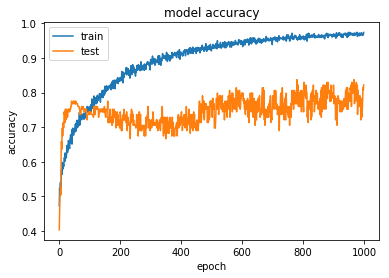

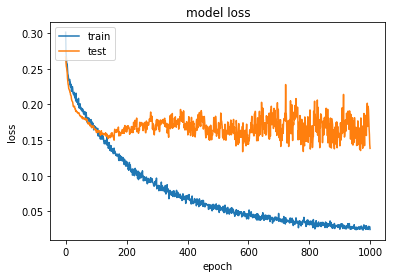

In [8]:
# Now, fit the model to the data
history = model.fit([x, params], y, validation_data=([x_dev, params_dev], y_dev), epochs=1000, batch_size=128)

# List all data in history
print(history.history.keys())
# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### Load pretrained conv model

In [47]:
# load json and create model
json_file = open('trained/conv_model_quickngood.json', 'r')
conv_model_json = json_file.read()
json_file.close()
model = model_from_json(conv_model_json)
# load weights into new model
model.load_weights("trained/conv_model_quickngood.h5")
print("Loaded model from disk")

Loaded model from disk


##### Additional model evaluation

In [20]:
# Evaluate model, get metrics back
stats = model.evaluate([x_dev, params_dev], y_dev)
# Calculate predictions vector from model
predictions = model.predict([x_dev, params_dev])
predictions = np.floor(predictions + 0.5)

# Get vector mask for good and bad fits and right and wrong answers
good_fits = y_dev
bad_fits = 1 - good_fits
wrong_answers = np.abs(np.subtract(predictions, good_fits))
right_answers = np.subtract(1, wrong_answers)
# Calculate true positives (tp), as well as (tn) (fp) (fn)
true_positives = np.multiply(right_answers, good_fits)
true_negatives = np.multiply(right_answers, bad_fits)
false_positives = np.multiply(wrong_answers, good_fits)
false_negatives = np.multiply(wrong_answers, bad_fits)
# Calculate additional metrics
precision = np.sum(true_positives) / np.sum(true_positives + false_positives)
recall = np.sum(true_positives) / np.sum(true_positives + false_negatives)

# Print stats
print()
print("Performance on VALIDATION set")
print(".............................")
print("Loss: " + str(stats[0]))
print("Accuracy: " + str(stats[1]))
print("Precision: " + str(precision))
print("Recall: " + str(recall))

# Print list of indices of wrong answers
bad_list = []
for i in range(m_dev):
    if wrong_answers[i] == 1:
        bad_list.append(i)
print(".............................")
print("List of indices of wrong guesses:")
print(bad_list)

129/129 [==============================] - 0s 2ms/step

Performance on VALIDATION set
.............................
Loss: 0.1132218891266524
Accuracy: 0.8372093023255814
Precision: 0.9107142857142857
Recall: 0.7611940298507462
.............................
List of indices of wrong guesses:
[3, 10, 14, 17, 18, 35, 42, 43, 46, 47, 49, 53, 74, 83, 85, 88, 97, 104, 105, 113, 121]


##### Look at an image

label: [1]
prediction: [0.]
(236, 348, 3)


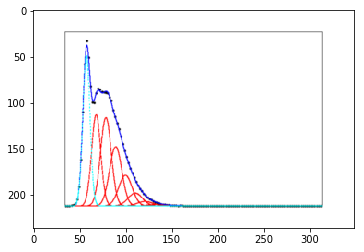

In [22]:
# Choose an index 
index = 10

# Print labels for this index
print("label: " + str(good_fits[index]))
print("prediction: " + str(predictions[index]))

# Show image
this_image = x[index]
print(str(this_image.shape))
plt.imshow(np.uint8(utils.get_printable_image(this_image)))

##### Save convolutional model to disc

In [24]:
#plot_model(simple_model, to_file='simple_model.png')
#SVG(model_to_dot(simple_model).create(prog='dot', format='svg'))

# serialize model to JSON
model_json = model.to_json()
with open("trained/conv_model_all_1000.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("trained/conv_model_all_1000.h5")
print("Saved model to disk")

Saved model to disk
